# Raport nr 1, Symulacje komputerowe

###  Emil Olszewski, Artur Sadurski  
---  

**Zadanie 1**  
Generator liczb pseudolosowych

In [32]:
using Plots
using Distributions
using HypothesisTests
using BenchmarkTools
using Statistics

Poniżej znajduje się implementacja generatora MRG32k3a liczb pseudolosowych z rozkładu jednostajnego na odcinku [0, 1]

In [2]:
function MRG32k3a(
    size, 
    seedx = [1822406609, 1153072917, 1254937013], 
    seedy = [2311980605, 7239483046, 2394024690]
    )

    result = Vector{Float64}(undef, size)

    m1 = 2^32 - 209
    m2 = 2^32 - 22853

    for i in 1:size

        x = mod((1403580seedx[2] - 810728seedx[3]), m1)
        y = mod((527612seedy[1] - 1370589seedy[3]), m2)

        result[i] = ifelse(x > y, (x - y) / (m1 + 1), (x - y + m1) / (m1 + 1))

        # Do generowania realizacji zmiennej losowej potrzebujemy tylko 3 ostatnich 
        # wartości x i y. Tym samym seedx i seedy możemy traktować jako kolejkę, w
        # każdej iteracji odrzucając wartości z końca i dodanie nowo obliczonych 
        # wartości do początku. 
        
        pop!(seedx); pop!(seedy)
        pushfirst!(seedx, x); pushfirst!(seedy, y)

    end

    return result

end

MRG32k3a (generic function with 3 methods)

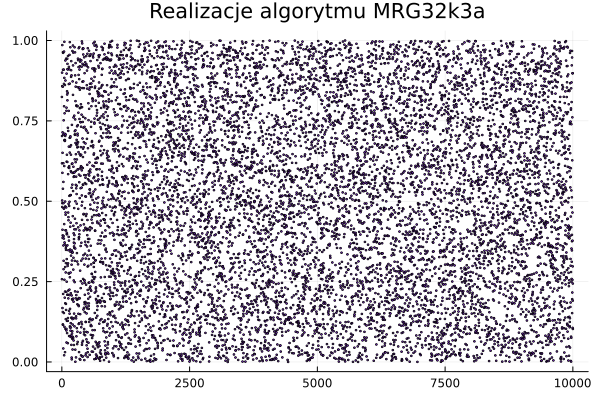

In [45]:
UNIFORM_SAMPLE_SIZE = 10_000
mrg_samples = MRG32k3a(UNIFORM_SAMPLE_SIZE)
scatter(mrg_samples, markersize=1, color=:blueviolet, legend=nothing, title="Realizacje algorytmu MRG32k3a")

Jak widać liczby generowane przez *MRG32k3a* rozkładają się w miarę równomiernie na odcinku [0, 1]. Skłania nas to do stwierdzenia, że pochodzą one z rozkładu U(0, 1). Aby potwierdzić tą hipotezę, wykonamy histogram generowanych wartości.

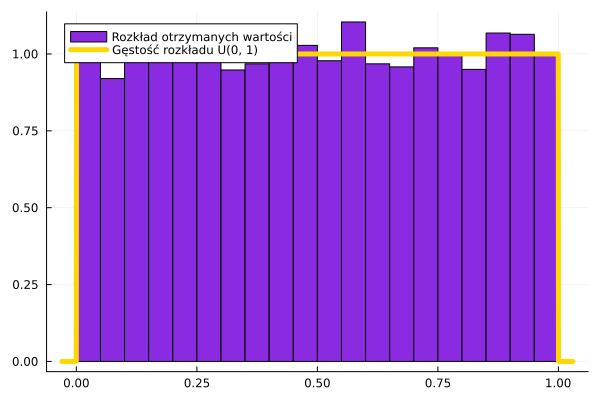

In [46]:
histogram(mrg_samples, color=:blueviolet, label="Rozkład otrzymanych wartości", normalize=:pdf)
plot!(x -> (0 < x < 1), lw=5, color=:gold, label="Gęstość rozkładu U(0, 1)")

Powyższy histogram dobrze obrazuje jednostajność generowanych wartości. Nie dowodzi to jednak niezależności. Sprawdzimy teraz kilka cech, które powinny charakteryzować ciąg niezależnych zmiennych losowych. 

* $Cov(X,Y) = 0$  
   
Jeśli dwie zmienne losowe są niezależne, to $$Cov(X, Y) = E(XY) - E(X)E(Y) = 0$$  
Zauważmy, że implikacja w drugą stronę nie zachodzi, jednakże wytępowanie powyższej równości, może być przesłanką za niezależnością zmiennych.

In [44]:
covariances = ones(100)

for i in 1:100
    seedx1 = rand(Int, 3)
    seedy1 = rand(Int, 3)
    X = MRG32k3a(100_000, rand(Int, 3), rand(Int, 3))
    Y = MRG32k3a(100_000, rand(Int, 3), rand(Int, 3))
    covariances[i] = mean(X .* Y) - mean(X) * mean(Y)
end

mean(abs.(covariances))

0.00019258378010503758

Jak widać, średnia wartość modułu kowariancjii jest bardzo mała, co może świadczyć o niezależności ciągów generowanych przez algorytm *MRG32k3a* z losowym ziarnem.

* Rozkład zmiennej $|X - Y|$
  
Sprawdzimy teraz czy kolejne wartości ciągu generowanego przez algorytm są niezależne względem siebie. Jeśli następujące po sobie wartości *iid* (independent, identically distrubuted), to rozkład $|x[i + 1] - x[i]|$ zadany jest wzorem 

$$ f(x) = 2\,\int_0^\infty g(x + y)g(y)\,dy = 2(1 - x) \quad dla \; x \in [0,1]$$  

gdzie $g(x)$ jest gęstością rozkładu jednostajnego na odcinku [0, 1].  
Powyższe równanie wynika ze wzoru na gęstość różnicy niezależnych zmiennych losowych i gęstość odwzorowania zmiennej losowej przez funkcję mierzalną. 

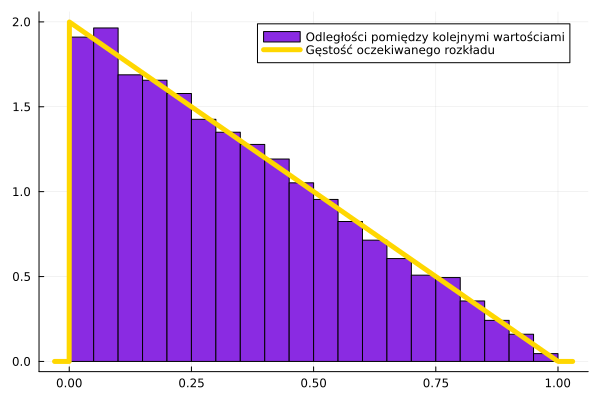

In [49]:
distances = [abs(mrg_samples[i + 1] - mrg_samples[i]) for i in 1:UNIFORM_SAMPLE_SIZE - 1]
histogram(distances, color=:blueviolet, label="Odległości pomiędzy kolejnymi wartościami", normalize=:pdf)
plot!(x -> 2 * (1 - x) * (0 < x < 1), lw = 5, color=:gold, label="Gęstość oczekiwanego rozkładu")

Jak widać histogram odległości między wartościami pasuje do wyznaczonego wcześniej rozkładu. Jest to kolejna przesłanka za tym, że algorytm generuje wartości *iid*. 

Na sam koniec porównamy wydajność naszego algorytmu do wbudowanej funkcji *rand*

In [54]:
@benchmark MRG32k3a(UNIFORM_SAMPLE_SIZE)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  320.700 μs …  11.957 ms  ┊ GC (min … max): 0.00% … 94.75%
 Time  (median):     375.200 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   426.716 μs ± 260.636 μs  ┊ GC (mean ± σ):  1.62% ±  2.93%

   ▅▇█▆▅                                                         
  ▂█████▇▄▃▃▃▃▄▃▄▃▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  321 μs           Histogram: frequency by time          986 μs <

 Memory estimate: 78.48 KiB, allocs estimate: 6.

In [55]:
@benchmark rand(UNIFORM_SAMPLE_SIZE)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  17.000 μs …  11.320 ms  ┊ GC (min … max):  0.00% … 99.26%
 Time  (median):     30.500 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   42.710 μs ± 211.248 μs  ┊ GC (mean ± σ):  14.92% ±  3.12%

   ▄█                                                           
  ▃██▆▅▃▃▅▅▃▃▂▃▅▆▄▄▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  17 μs           Histogram: frequency by time          117 μs <

 Memory estimate: 78.17 KiB, allocs estimate: 2.